# Distribution Schema Tutorial

This tutorial will walk you through using the distribution schema system. The boston housing dataset is used for the tutorial.

There is also a section which provides guidance for future contributions to the distribution code base.

NOTE: Pytorch is required for this tutorial.

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join("../../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

Taking a look at the Boston Housing Data:

In [5]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
data = load_boston()
print(data["DESCR"])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [ ]:
df = pd.DataFrame(data.data, columns=data["feature_names"])
df["MEDV"] = data.target
df.head()

Taking a look at the data below, we can naturally group the data into various distributions may fit the data better:

Generic Continuous:

- CRIM

- NOX

- RM

- DIS

- TAX

- MEDV

Proportion (0, 1 bounded):

- ZN

- INDUS

- AGE

- PTRATIO

- LSTAT

Binary:

- CHAS

Categorical:

- RAD

We can use a schema to identify other distribution types so that the fit is more accurate.

**NOTE** the distributional assumptions must be *conditional* on the causal variables X:

$$ p(y | X ; \theta)  \sim Dist $$

Often the normal distribution is taken as a good approximation for generic continuous data.

The schema is just a dictionary object which maps the column name to the string alias distribution type:

schema: {col\_name : dist\_type\_alias}

A list of the supported distribution types and their string aliases can be found in:

`causalnex/structure/pytorch/dist_type/__init__.py`

More distributions allow causalnex to be used on a wider variety of datasets. Please see the `Developer Guide` section below if you are interested in helping out!

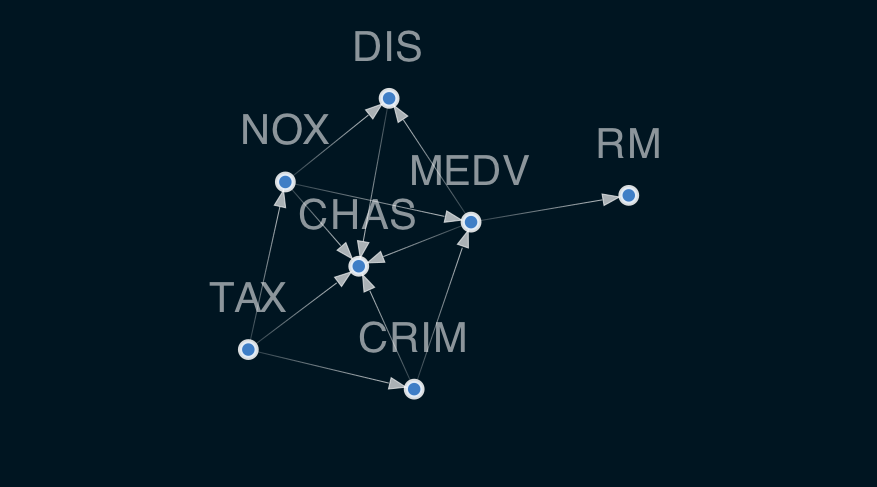

In [25]:
# currently causalnex only supports continuous and binary data
cont_cols = ['CRIM', 'NOX', 'RM', 'DIS', 'TAX', 'MEDV']
bin_cols = ['CHAS']

# subset data for which there is an avaliable schema
all_cols = cont_cols + bin_cols
df_subset = df[all_cols]
# current gaussian distribution assumes unit variance
df_subset[cont_cols] = (df_subset[cont_cols] - df_subset[cont_cols].mean())  / df_subset[cont_cols].std()

# insert into schema as colname:dist_type
schema = {}
for col in bin_cols:
    schema[col] = "bin"
for col in cont_cols:
    schema[col] = "cont"

# NOTE: only the pytorch version supports multiple distribution types at the moment
from causalnex.structure.pytorch import from_pandas
sm = from_pandas(df_subset, dist_type_schema=schema, lasso_beta=1e-5, w_threshold=0.0, use_bias=True)
sm.threshold_till_dag()


from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
viz = plot_structure(
    sm, 
    graph_attributes={"scale": "0.5"}, 
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

___

## Developer Guide

The distributions are kept in `causalnex/structure/pytorch/dist_type/`. If you want to read through already implemented distributions, take a look there.

### Single Parameter Distribution

Contributing new single-parameter distributions is very simple. The steps are as follows:

- subclass `causalnex/structure/pytorch/dist_type/_base/DistTypeBase`

- fill in the negative-log-likelihood as the "loss" method

- fill in the inverse link function

Each `DistType` class uses the `self.idx` attribute to select the data column which it corresponds to.

Multi-parameter distributions will be covered in a separate post.

The poisson dist type is shown below as an example:


In [26]:
import torch
import torch.nn as nn

from causalnex.structure.pytorch.dist_type._base import DistTypeBase


class DistTypePoisson(DistTypeBase):
    """ Class defining poisson distribution type functionality """

    def loss(self, X: torch.Tensor, X_hat: torch.Tensor) -> torch.Tensor:
        """
        https://pytorch.org/docs/master/generated/torch.nn.PoissonNLLLoss.html
        Uses the functional implementation of the PoissonNLL class.
        Returns the elementwise Poisson Negative Log Likelihood loss.

        Args:
            X: The original data passed into NOTEARS (i.e. the reconstruction target).

            X_hat: The reconstructed data.

        Returns:
            Scalar pytorch tensor of the reconstruction loss between X and X_hat.
        """
        return nn.functional.poisson_nll_loss(
            input=X_hat[:, self.idx],
            target=X[:, self.idx],
            reduction="mean",
            log_input=True,
            full=False,
        )

    def inverse_link_function(self, X_hat: torch.Tensor) -> torch.Tensor:
        """
        Exponential inverse link function for poisson data.

        Args:
            X_hat: Reconstructed data in the latent space.

        Returns:
            Modified X_hat.
            MUST be same shape as passed in data.
            Projects the self.idx column from the latent space to the dist_type space.
        """
        X_hat[:, self.idx] = torch.exp(X_hat[:, self.idx])
        return X_hat

### Multi Parameter Distributions

These are a little bit more tricky.

Multi-parameter Vector GLMs generally work by expanding the column space. Each column then becomes responsible for fitting a separate parameter. There are generally two types of column expansion:

- Column duplication (fit only). These are commonly used for multiparameter distributions, for example fitting the mean and std of a gaussian distribution. The expanded columns are _NOT_ used as features in prediction.

- Column expansion (fit and predict). These are used when the column expansion is also used to predict, as in the case of categorical distributions.

The below code sample shows a column expansion example. The additional methods which need to be changed by the user are:

- get_columns

- preprocess_X

- preprocess_tabu_edges

- preprocess_tabu_nodes

- modify h

- add_to_node

- update_idx_col

In [ ]:
from copy import deepcopy
from typing import Dict, List, Tuple

import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import OneHotEncoder

from causalnex.structure.pytorch.dist_type._base import DistTypeBase, ExpandColumnsMixin
from causalnex.structure.structuremodel import StructureModel


class DistTypeCategorical(ExpandColumnsMixin, DistTypeBase):
    """ Class defining categorical distribution type functionality """

    # index group of categorical columns
    idx_group = None
    # column expander for later preprocessing
    encoder = None

    def get_columns(
        self,
        X: np.ndarray,
    ) -> np.ndarray:
        """
        Gets the column(s) associated with the instantiated DistType.

        Args:
            X: Full dataset to be selected from.

        Returns:
            1d or 2d np.ndarray of columns.
        """
        return X[:, self.idx_group]

    def preprocess_X(self, X: np.ndarray, fit_transform: bool = True) -> np.ndarray:
        """
        Expands the feature dimension for each categorical column by:
        - One hot encode each of the categorical features
        - For each feature, get handle on groups of one-hot expanded columns
        - Store the handle groups
        - Return expanded array
        NOTE: the number of expanded columns is EQUAL to the number of classes
        for ease of use with the Pytorch loss functions.
        This is technically wasteful computationally (only need C-1 columns).

        Args:
            X: The original passed-in data.

            fit_transform: Whether the class first fits
            then transforms the data, or just transforms.
            Just transforming is used to preprocess new data after the
            initial NOTEARS fit.

        Returns:
            Preprocessed X
        """
        # deepcopy to prevent overwrite errors
        X = deepcopy(X)

        # fit the OneHotEncoder
        if fit_transform:
            self.encoder = OneHotEncoder(sparse=False, categories="auto", drop=None)
            self.encoder.fit(X[:, [self.idx]])

        # expand columns for this feature
        expanded_columns = self.encoder.transform(X[:, [self.idx]])
        # update the original column with the first expanded column
        X[:, self.idx] = expanded_columns[:, 0]
        # append the remainder cols to X
        X = self._expand_columns(X, expanded_columns[:, 1:])

        # update the idx_group with expanded columns
        if fit_transform:
            self.idx_group = []
            # preserve the first column location
            self.idx_group.append(self.idx)
            # the new cols are appended to the end of X contiguously
            n_new_cols = expanded_columns.shape[1] - 1
            idx_start = X.shape[1] - n_new_cols
            # preserve location of expanded columns
            self.idx_group += list(range(idx_start, X.shape[1]))

        return X

    def preprocess_tabu_edges(
        self, tabu_edges: List[Tuple[int, int]]
    ) -> List[Tuple[int, int]]:
        """
        Update tabu_edges taking into account expanded columns.

        Args:
            tabu_edges: The original tabu_edges.

        Returns:
            Preprocessed tabu_edges.
        """
        return self.update_tabu_edges(
            idx_group=self.idx_group, tabu_edges=tabu_edges, tabu_idx_group=True
        )

    def preprocess_tabu_nodes(self, tabu_nodes: List[int]) -> List[int]:
        """
        Update tabu_nodes taking into account expanded columns.

        Args:
            tabu_nodes: The original tabu_nodes.

        Returns:
            Preprocessed tabu_nodes.
        """
        return self.update_tabu_nodes(idx_group=self.idx_group, tabu_nodes=tabu_nodes)

    def modify_h(self, square_weight_mat: torch.Tensor) -> torch.Tensor:
        """
        Used to prevent spurious cycles between expanded columns and other features.
        For example, A_cat1 -> B -> A_cat2 would not be penalized by the h(W) constraint.

        This modification solves that by adding the expanded columns of the
        squared adjacency matrix onto the original column. This effectively superimposes
        All expanded column connections onto a single connection

        Args:
            square_weight_mat: The squared adjacency matrix used in h(W).

        Returns:
            The modified W matrix.
        """
        orig_idx = self.idx_group[0]
        expand_idx = self.idx_group[1:]

        # Add on the edges from expanded nodes.
        square_weight_mat[orig_idx, :] = square_weight_mat[orig_idx, :] + torch.sum(
            square_weight_mat[expand_idx, :], dim=0
        )
        # Add on the edges to expanded nodes.
        square_weight_mat[:, orig_idx] = square_weight_mat[:, orig_idx] + torch.sum(
            square_weight_mat[:, expand_idx], dim=1
        )

        return square_weight_mat

    @staticmethod
    def _to_index(X_one_hot: torch.Tensor) -> torch.Tensor:
        """
        Recover the numerical columns by argmaxing a one-hot vector.

        Args:
            X_one_hot: The one-hot tensor to be collapsed.

        Returns:
            A 1d tensor representing the classes defined by the above one-hot
            tensor.
        """
        return torch.argmax(X_one_hot, dim=1)

    def add_to_node(self, sm: StructureModel) -> StructureModel:
        """
        Adds self to a node of a structure model corresponding to
        all indexes in self.idx_group.

        Args:
            sm: The input StructureModel

        Returns:
            Updated StructureModel
        """
        for idx in self.idx_group:
            sm.nodes[idx]["dist_type"] = self
        return sm

    def loss(self, X: torch.Tensor, X_hat: torch.Tensor) -> torch.Tensor:
        """
        Uses the functional implementation of the CrossEntropyLoss class
        https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss.

        Returns the mean row wise cross entropy loss for a single group of categorical columns.

        NOTE: the pytorch implementation assumes a numeric target input.
        Therefore, collapse the one hot columns into a numeric target column.

        Args:
            X: The original data passed into NOTEARS (i.e. the reconstruction target).

            X_hat: The reconstructed data.

        Returns:
            Scalar pytorch tensor of the reconstruction loss between X and X_hat.
        """

        return nn.functional.cross_entropy(
            input=X_hat[:, self.idx_group],
            target=self._to_index(X[:, self.idx_group]),
            reduction="mean",
        )

    def inverse_link_function(self, X_hat: torch.Tensor) -> torch.Tensor:
        """
        Softmax inverse link function for categorical data.

        Args:
            X_hat: Reconstructed data in the latent space.

        Returns:
            Modified X_hat.
            MUST be same shape as passed in data.
            Projects the self.idx column from the latent space to the dist_type space.
        """
        X_hat[:, self.idx_group] = torch.softmax(X_hat[:, self.idx_group], dim=1)
        return X_hat

    @staticmethod
    def make_node_name(colname: str, catidx: int) -> str:
        """
        Renaming scheme for expanded categorical columns.
        NOTE: column is not renamed if catidx is 0.
        This is bc original column name needs to stay constant.

        Args:
            colname: The base column used in the renaming.

            catidx: The index of the categorical expansion.

        Returns:
            Updated column name.
        """
        if catidx:
            return f"{colname}{catidx}"
        return colname

    def update_idx_col(self, idx_col: Dict[int, str]) -> Dict[int, str]:
        """
        Expand the named columns to include category names.

        Args:
            idx_col: The original index to column mapping.

        Returns:
            Updated index to column mapping.
        """
        new_idx_cols = {}
        colname = idx_col.pop(self.idx_group[0])
        for catidx, idx in enumerate(self.idx_group):
            new_idx_cols[idx] = self.make_node_name(colname, catidx)
        return {**idx_col, **new_idx_cols}
